**L'objectif de ce notebook est d'analyser les erreurs faites par les deux modèles de classification retenus (avec et sans rééquilibrage de classes) dans le notebook 2_1 Feature Engineering&Modeling.**

**La partie 1. de ce notebook reprend le preprocessing détaillé dans le notebook 2_ Feature Engineering&Modeling.**
**Les parties 2 et 4 de ce notebook reprennent les deux modèles sélectionnés dans le notebook  2_1 Feature Engineering&Modeling.**

**L'analyse des erreurs ne concerne que les parties 3 et 5 de ce notebook.**



# **1. Bibliothèques, données et preprocessing**

**Importation des bibliothèques**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import svm

from sklearn import metrics 
from sklearn.metrics import classification_report

from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.metrics import f1_score


**Importation des datasets**

In [2]:

df_depart = pd.read_csv('data/weatherAus.csv')

df = pd.read_excel('dataset.xlsx', index_col=0)


**Preprocessing : numérisation des variables catégorielles**

In [3]:
# Numérisation des variables 'RainTomorrow' et'RainToday' :

df['RainTomorrow'] = df['RainTomorrow'].replace(['No','Yes'],[0,1])
df['RainToday'] = df['RainToday'].replace(['No','Yes'],[0,1])

cat = [var for var in df.columns if df[var].dtype == 'object']

print('il reste ',len(cat),'variables catégorielles :', cat)


il reste  4 variables catégorielles : ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']


In [4]:
# Numérisation des variables circulaires à l'aide de la fonction trigonométrique cosinus.

df['WindGustDir'] = df['WindGustDir'].replace(['E', 'ENE', 'NE','NNE', 'N', 'NNW', 'NW', 'WNW','W',  'WSW', 'SW','SSW', 'S',
    'SSE', 'SE', 'ESE'],[np.cos(np.pi *k/8) for k in range(16)] ).astype(np.float64)

df['WindDir9am'] = df['WindDir9am'].replace(['E', 'ENE', 'NE','NNE', 'N', 'NNW', 'NW', 'WNW','W',  'WSW', 'SW','SSW', 'S',
    'SSE', 'SE', 'ESE'],[np.cos(np.pi *k/8) for k in range(16)] ).astype(np.float64)

df['WindDir3pm'] = df['WindDir3pm'].replace(['E', 'ENE', 'NE','NNE', 'N', 'NNW', 'NW', 'WNW','W',  'WSW', 'SW','SSW', 'S',
    'SSE', 'SE', 'ESE'],[np.cos(np.pi *k/8) for k in range(16)] ).astype(np.float64)


In [5]:
# dichotomisation de la variable 'Location'

df = df.join(pd.get_dummies(df['Location'],prefix='Loc'))
df = df.drop('Location', axis=1)


**Gestion des Nans 'Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am' :**


In [6]:
# suppression des lignes pour lesquelles les variables 'Sunshine','Evaporation','Cloud3pm' et 'Cloud9am' présentent des valeurs manquantes 

df.dropna(subset=['Sunshine','Evaporation','Cloud3pm','Cloud9am'], inplace=True)


**Séparation du jeu de données en variables explicatives et variable cible :**

In [7]:
data = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']


**Séparation des données en jeu d'entraînement et jeu de test :**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,  random_state=1234)


**Gestion des valeurs manquantes restantes :**

In [9]:
for var in X_train.columns :
  if X_train[var].isna().sum() !=0 :
    var_mediane = X_train[var].median()
    X_train[var] = X_train[var].fillna(var_mediane)

X_train.isna().sum().sum()

for var in X_test.columns :
  if X_test[var].isna().sum() !=0 :
    var_mediane = X_test[var].median()
    X_test[var] = X_test[var].fillna(var_mediane)
    

C:\Users\33661\AppData\Local\Temp/ipykernel_10784/1839007586.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[var] = X_train[var].fillna(var_mediane)
C:\Users\33661\AppData\Local\Temp/ipykernel_10784/1839007586.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[var] = X_test[var].fillna(var_mediane)


In [10]:
# Vérification qu'il n'y a plus de valeurs manquantes :

X_train.isna().sum().sum(), X_test.isna().sum().sum()


(0, 0)

**Gestion des outliers :**

In [11]:
# Traitement des outliers identifiés dans la partie exploratoire dans les jeux d'entrainement et de test.

def val_max(df, var, max) :
  return np.where(df[var] > max, max, df[var])

X_train['Rainfall'] = val_max(X_train, 'Rainfall', 3.2)
X_train['Evaporation'] = val_max(X_train, 'Evaporation', 21.8)
X_train['WindGustSpeed'] = val_max(X_train, 'WindGustSpeed', 99)
X_train['WindSpeed9am'] = val_max(X_train, 'WindSpeed9am', 55)
X_train['WindSpeed3pm'] = val_max(X_train, 'WindSpeed3pm', 57)


X_test['Rainfall'] = val_max(X_test, 'Rainfall', 3.2)
X_test['Evaporation'] = val_max(X_test, 'Evaporation', 21.8)
X_test['WindGustSpeed'] = val_max(X_test, 'WindGustSpeed', 99)
X_test['WindSpeed9am'] = val_max(X_test, 'WindSpeed9am', 55)
X_test['WindSpeed3pm'] = val_max(X_test, 'WindSpeed3pm', 57)


C:\Users\33661\AppData\Local\Temp/ipykernel_10784/118492435.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Rainfall'] = val_max(X_train, 'Rainfall', 3.2)
C:\Users\33661\AppData\Local\Temp/ipykernel_10784/118492435.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Evaporation'] = val_max(X_train, 'Evaporation', 21.8)
C:\Users\33661\AppData\Local\Temp/ipykernel_10784/118492435.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

**Standardisation des données :**

In [12]:
col = [X_train.columns]

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=col)
X_test = pd.DataFrame(X_test, columns=col)


# **2. Premier modèle retenu : SVM (C=10, gamma=0.01, kernel='rbf') sur jeu non rééquilibré**


**entraînement du modèle et prédiction :**

In [13]:
clf = svm.SVC(C=10, gamma=0.01, kernel='rbf')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))

pd.crosstab(y_test, y_pred, rownames=['classe réelle'], colnames=['classe predite'])




 Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      9647
           1       0.79      0.55      0.65      2812

    accuracy                           0.87     12459
   macro avg       0.83      0.75      0.78     12459
weighted avg       0.86      0.87      0.86     12459



classe predite,0,1
classe réelle,,
0,9228,419
1,1257,1555


# **3. Analyse des erreurs de prédictions de ce premier modèle**

**Création d'un dataframe contenant uniquement la cible réelle et prédite : df_realite_pred**

In [14]:
df_realite_pred = pd.DataFrame(y_test).rename({'RainTomorrow': 'Realite'}, axis=1)
df_realite_pred['Prediction'] = y_pred

print(df_realite_pred.shape)
df_realite_pred.head()


(12459, 2)


,Realite,Prediction
100743,0,0
71205,0,0
87728,0,0
139970,0,0
76944,0,0


## **3.1 Les faux négatifs**

**Création d'un tableau contenant uniquement les faux négatifs :**

In [15]:
df_faux_neg = df_realite_pred[(df_realite_pred['Prediction']==0) & (df_realite_pred['Realite']==1)]

print(df_faux_neg.shape)
df_faux_neg.head()


(1257, 2)


,Realite,Prediction
69190,1,0
80383,1,0
30557,1,0
85237,1,0
64786,1,0


**Ajout à ce tableau des hauteurs de pluie du lendemain :**

In [16]:
L = []
for i in df_faux_neg.index :
  if df_depart.loc[i+1]['Location']==df_depart.loc[i]['Location'] :
    L.append(df_depart.loc[i+1]['Rainfall'])
  else :
    L.append(np.nan)

df_faux_neg['hauteur_pluie_lendemain'] = L
df_faux_neg.head()


C:\Users\33661\AppData\Local\Temp/ipykernel_10784/3993921262.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_faux_neg['hauteur_pluie_lendemain'] = L


,Realite,Prediction,hauteur_pluie_lendemain
69190,1,0,2.2
80383,1,0,1.8
30557,1,0,3.8
85237,1,0,2.0
64786,1,0,1.2


In [17]:
df_faux_neg.isna().sum()

Realite                    0
Prediction                 0
hauteur_pluie_lendemain    1
dtype: int64

In [18]:
df_faux_neg.dropna(inplace=True)
df_faux_neg.isna().sum()

C:\Users\33661\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Realite                    0
Prediction                 0
hauteur_pluie_lendemain    0
dtype: int64

**Statistiques des faux négatifs :**

In [19]:
pd.DataFrame(df_faux_neg['hauteur_pluie_lendemain'].describe())


,hauteur_pluie_lendemain
count,1256.000000
mean,6.505573
std,9.506017
min,1.200000
25%,2.000000
50%,3.200000
75%,6.800000
max,104.800000


**Lorsque le modèle ne prévoit pas la pluie du lendemain, la moyenne des hauteurs de précipitations du lendemain est de 6.51 mm.**

## **3.2 Les vrais positifs**

**Création d'un tableau contenant uniquement les vrais positifs :**

In [20]:
df_vrai_pos = df_realite_pred[(df_realite_pred['Prediction']==1) & (df_realite_pred['Realite']==1)]

print(df_vrai_pos.shape)
df_vrai_pos.head()


(1555, 2)


,Realite,Prediction
64516,1,1
71906,1,1
109355,1,1
42093,1,1
140082,1,1


**Ajout à ce tableau des hauteurs de pluie du lendemain :**

In [21]:
L = []
for i in df_vrai_pos.index :
   if df_depart.loc[i+1]['Location']==df_depart.loc[i]['Location'] :
    L.append(df_depart.loc[i+1]['Rainfall'])
   else :
    L.append(np.nan)

df_vrai_pos['hauteur_pluie_lendemain'] = L
df_vrai_pos.head()


C:\Users\33661\AppData\Local\Temp/ipykernel_10784/927957372.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vrai_pos['hauteur_pluie_lendemain'] = L


,Realite,Prediction,hauteur_pluie_lendemain
64516,1,1,18.0
71906,1,1,5.8
109355,1,1,10.8
42093,1,1,13.6
140082,1,1,8.6


In [22]:
df_vrai_pos.isna().sum()

Realite                    0
Prediction                 0
hauteur_pluie_lendemain    0
dtype: int64

**Statistiques des vrais positifs :**

In [23]:
pd.DataFrame(df_vrai_pos['hauteur_pluie_lendemain'].describe())



,hauteur_pluie_lendemain
count,1555.000000
mean,14.685338
std,22.525018
min,1.200000
25%,3.600000
50%,7.600000
75%,16.400000
max,367.600000


**Lorsque le modèle prévoit correctement la pluie du lendemain, la moyenne des hauteurs de précipitations du lendemain est de 14.69 mm.**

**Bilan - Si dans la réalité il pleut le lendemain, comparaison des hauteurs de précipitations lorsque le modèle prédit ou non la pluie :**

''

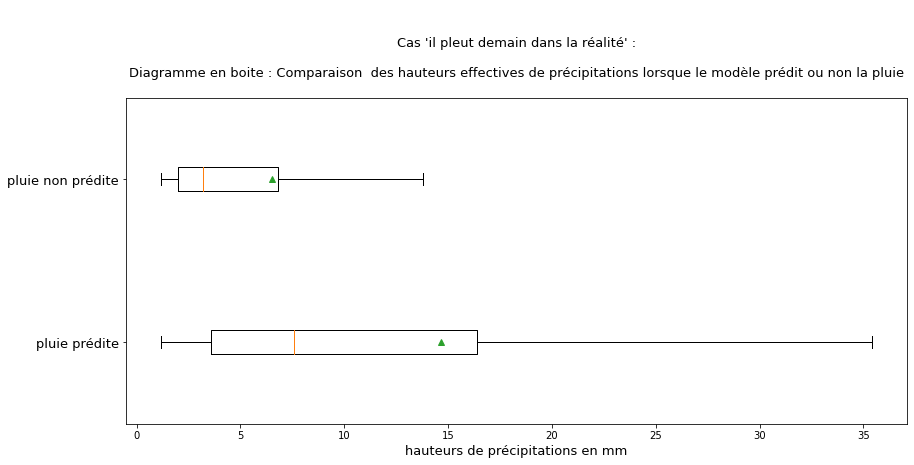

In [24]:
plt.figure (figsize=(14,6))

plt.boxplot([df_vrai_pos['hauteur_pluie_lendemain'], df_faux_neg['hauteur_pluie_lendemain']], sym='', vert=False,showmeans=True)
plt.xlabel('hauteurs de précipitations en mm', size=13)
plt.yticks([1,2],['pluie prédite','pluie non prédite'], size=13)
plt.title("\n\nCas 'il pleut demain dans la réalité' :\n\nDiagramme en boite : Comparaison  des hauteurs effectives de précipitations lorsque le modèle prédit ou non la pluie\n", size=13)
;


**Conclusion - Lorsqu'il pleut dans la réalité le lendemain :**

**Ce diagramme en boite montre clairement que lorsque notre premier modèle retenu ne détecte pas la pluie du lendemain, les précipitations sont beaucoup plus faibles que lorsque le modèle la détecte :**

*** Si la pluie est détectée, la moyenne des précipitations est de 14.7 mm contre 6.5 mm si elle n'est pas détectée.**

*** 25 % des pluies non détectées sont inférieures à 2 mm alors que 25 % des pluies détectées sont inférieures à 3.6 mm (Q1).**

*** 50 % des pluies non détectées sont inférieures à 3.2 mm alors que 50 % des pluies détectées sont inférieures à 7.6 mm (médiane).**

*** 75 % des pluies non détectées sont inférieures à 6.8 mm alors que 75 % des pluies détectées sont inférieures à 16.4 mm (Q3).**



## **3.3 Les faux positifs**

**Création d'un tableau contenant uniquement les faux positifs :**

In [25]:
df_faux_pos = df_realite_pred[(df_realite_pred['Prediction']==1) & (df_realite_pred['Realite']==0)]

print(df_faux_pos.shape)
df_faux_pos.head()


(419, 2)


,Realite,Prediction
34087,0,1
80419,0,1
9079,0,1
39845,0,1
100802,0,1



**Ajout à ce tableau des hauteurs de pluie du lendemain :**

In [26]:
L = []
for i in df_faux_pos.index :
  if df_depart.loc[i+1]['Location']==df_depart.loc[i]['Location'] :
    L.append(df_depart.loc[i+1]['Rainfall'])
  else :
    L.append(np.nan)
df_faux_pos['hauteur_pluie_lendemain'] = L
df_faux_pos.head()


C:\Users\33661\AppData\Local\Temp/ipykernel_10784/1630979418.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_faux_pos['hauteur_pluie_lendemain'] = L


,Realite,Prediction,hauteur_pluie_lendemain
34087,0,1,0.4
80419,0,1,0.0
9079,0,1,0.0
39845,0,1,0.0
100802,0,1,0.2


In [27]:
df_faux_pos.isna().sum()

Realite                    0
Prediction                 0
hauteur_pluie_lendemain    0
dtype: int64

**Statistiques des faux positifs :**

In [28]:
pd.DataFrame(df_faux_pos['hauteur_pluie_lendemain'].describe())


,hauteur_pluie_lendemain
count,419.000000
mean,0.359189
std,0.341374
min,0.000000
25%,0.000000
50%,0.300000
75%,0.600000
max,1.000000


In [29]:
p_FP = df_faux_pos[df_faux_pos['hauteur_pluie_lendemain']!=0].shape[0]/df_faux_pos.shape[0]*100

print('Dans',np.round(p_FP,2), '% des cas de faux positifs il y a tout de même de petites pluies (inférieures au seuil de 1 mm).\n')


Dans 66.59 % des cas de faux positifs il y a tout de même de petites pluies (inférieures au seuil de 1 mm).



**Conclusion :**

**Lorsque le modèle prévoit par erreur la pluie du lendemain, il y a tout de même de légères précipitations dans 66.59 % des cas mais de hauteur inférieure à 1mm, le seuil arbitrairement choisi (rappel : ne sont comptabilisées comme 'OUI' dans 'Rain Tomorrow' que les précipitations supérieures au seuil de 1 mm)**.

**La moyenne des hauteurs de précipitations du lendemain n'est donc pas nulle et vaut 0.36 mm.**


## **3.4 Les vrais négatifs**

**Création d'un tableau contenant uniquement les vrais négatifs :**

In [30]:
df_vrai_neg = df_realite_pred[(df_realite_pred['Prediction']==0) & (df_realite_pred['Realite']==0)]

print(df_vrai_neg.shape)
df_vrai_neg.head()


(9228, 2)


,Realite,Prediction
100743,0,0
71205,0,0
87728,0,0
139970,0,0
76944,0,0


**Ajout à ce tableau des hauteurs de pluie du lendemain :**

In [31]:
L = []
for i in df_vrai_neg.index :
  if df_depart.loc[i+1]['Location']==df_depart.loc[i]['Location'] :
    L.append(df_depart.loc[i+1]['Rainfall'])
  else :
    L.append(np.nan)
    
df_vrai_neg['hauteur_pluie_lendemain'] = L
df_vrai_neg.head()


C:\Users\33661\AppData\Local\Temp/ipykernel_10784/1057322026.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vrai_neg['hauteur_pluie_lendemain'] = L


,Realite,Prediction,hauteur_pluie_lendemain
100743,0,0,0.2
71205,0,0,0.0
87728,0,0,0.2
139970,0,0,0.0
76944,0,0,0.6


In [32]:
df_vrai_neg.isna().sum()

Realite                    0
Prediction                 0
hauteur_pluie_lendemain    3
dtype: int64

In [33]:
df_vrai_neg.dropna(inplace=True)
df_vrai_neg.isna().sum()

C:\Users\33661\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Realite                    0
Prediction                 0
hauteur_pluie_lendemain    0
dtype: int64

**Statistiques des vrais négatifs :**

In [34]:
pd.DataFrame(df_vrai_neg['hauteur_pluie_lendemain'].describe())


,hauteur_pluie_lendemain
count,9225.000000
mean,0.062190
std,0.181396
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [35]:
p_VN = df_vrai_neg[df_vrai_neg['hauteur_pluie_lendemain']!=0].shape[0]/df_vrai_neg.shape[0]*100

print('Dans',np.round(p_VN,2), '% des cas de vrais négatifs il y a tout de même de petites pluies (inférieures à 1 mm).\n')


Dans 14.46 % des cas de vrais négatifs il y a tout de même de petites pluies (inférieures à 1 mm).



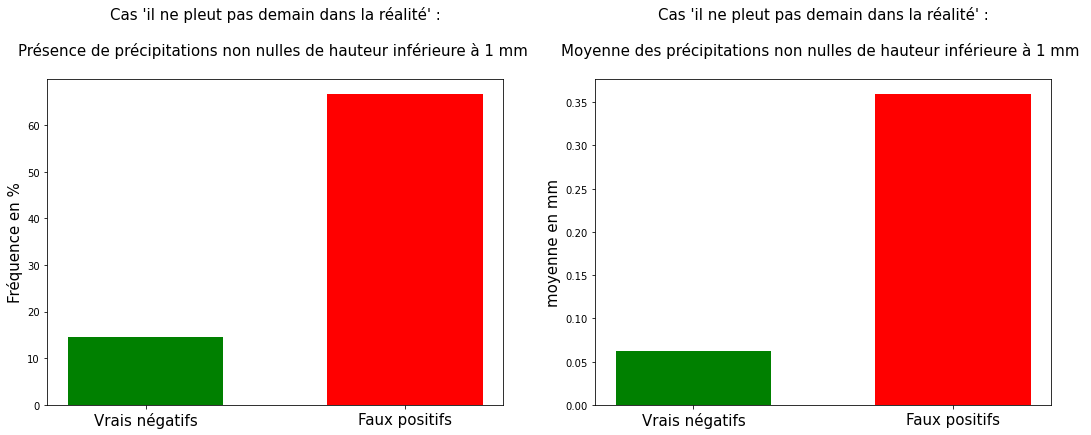

In [36]:
x = ['Vrais négatifs', 'Faux positifs']
y = [p_VN, p_FP]
z = [df_vrai_neg['hauteur_pluie_lendemain'].mean(), df_faux_pos['hauteur_pluie_lendemain'].mean()]
c = ['green','red']

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.bar(x,y, width=0.6, color=c)
plt.ylabel('Fréquence en %', size=15)
plt.xticks(size=15)
plt.title("Cas 'il ne pleut pas demain dans la réalité' :\n\nPrésence de précipitations non nulles de hauteur inférieure à 1 mm \n", size=15);

plt.subplot(1,2,2)
plt.bar(x,z, width=0.6, color=c)
plt.ylabel('moyenne en mm', size=15)
plt.xticks(size=15)
plt.title("Cas 'il ne pleut pas demain dans la réalité' :\n\nMoyenne des précipitations non nulles de hauteur inférieure à 1 mm \n", size=15);




**Conclusion dans le cas où dans la réalité il ne pleut pas le lendemain :**



**Lorsque le modèle prévoit avec justesse qu'il ne pleut pas le lendemain, il y a tout de même de légères précipitations dans 14.46 % des cas contre 66.59 % des cas lorsque le modèle prévoit par erreur la pluie.**

**Lorsque le modèle prévoit avec exactitude qu'il ne pleut pas, la moyenne des hauteurs de précipitations du lendemain est de 0.06 mm. Mais lorsque le modèle prévoit à tort qu'il va pleuvoir, la moyenne des hauteurs de précipitations du lendemain est plus élevée et est de 0.36 mm .**

**Les faibles précipitations (inférieures à 1 mm, non comptabilisées pour la pluie) incitent le modèle à se tromper en indiquant qu'il va pleuvoir le lendemain.**

# **4. Deuxième modèle retenu SVM (C=7, gamma=0.01, kernel='rbf') sur jeu rééquilibré**

**Rééquilibrage des classes :**

In [37]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.metrics import f1_score

rUs = RandomUnderSampler(random_state=28)
X_ru, y_ru = rUs.fit_resample(X_train,y_train)

print('y_ru : \n',y_ru.value_counts(), '\n')


y_ru : 
 0    11097
1    11097
Name: RainTomorrow, dtype: int64 



**Entraînement du modèle et prédiction :**

In [38]:
clf = svm.SVC(C=7, gamma=0.01, kernel='rbf')
clf.fit(X_ru, y_ru)
y_pred = clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
pd.crosstab(y_test,y_pred, rownames=['classe réelle'], colnames=['classe predite'])




 Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      0.81      0.87      9647
           1       0.56      0.82      0.67      2812

    accuracy                           0.82     12459
   macro avg       0.75      0.82      0.77     12459
weighted avg       0.85      0.82      0.83     12459



classe predite,0,1
classe réelle,,
0,7859,1788
1,506,2306


# **5. Analyse des erreurs de prédictions de ce deuxième modèle**

**Création d'un dataframe contenant uniquement la cible réelle et prédite : df_realite_pred**

In [39]:
df_realite_pred = pd.DataFrame(y_test).rename({'RainTomorrow': 'Realite'}, axis=1)
df_realite_pred['Prediction'] = y_pred

print(df_realite_pred.shape)
df_realite_pred.head()


(12459, 2)


,Realite,Prediction
100743,0,0
71205,0,0
87728,0,1
139970,0,0
76944,0,0


## **5.1 Les faux négatifs**

**Création d'un tableau contenant uniquement les faux négatifs :**

In [40]:
df_faux_neg = df_realite_pred[(df_realite_pred['Prediction']==0) & (df_realite_pred['Realite']==1)]

print(df_faux_neg.shape)
df_faux_neg.head()


(506, 2)


,Realite,Prediction
85237,1,0
35754,1,0
140006,1,0
87184,1,0
118596,1,0


**Ajout à ce tableau des hauteurs de pluie du lendemain :**

In [41]:
L = []
for i in df_faux_neg.index :
  if df_depart.loc[i+1]['Location']==df_depart.loc[i]['Location'] :
    L.append(df_depart.loc[i+1]['Rainfall'])
  else :
    L.append(np.nan)

df_faux_neg['hauteur_pluie_lendemain'] = L
df_faux_neg.head()


C:\Users\33661\AppData\Local\Temp/ipykernel_10784/3993921262.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_faux_neg['hauteur_pluie_lendemain'] = L


,Realite,Prediction,hauteur_pluie_lendemain
85237,1,0,2.0
35754,1,0,2.2
140006,1,0,3.0
87184,1,0,18.8
118596,1,0,13.0


In [42]:
df_faux_neg.isna().sum()

Realite                    0
Prediction                 0
hauteur_pluie_lendemain    0
dtype: int64

**Statistiques des faux négatifs :**

In [43]:
pd.DataFrame(df_faux_neg['hauteur_pluie_lendemain'].describe())


,hauteur_pluie_lendemain
count,506.000000
mean,5.058893
std,6.668642
min,1.200000
25%,1.600000
50%,2.800000
75%,5.200000
max,70.000000


**Lorsque le modèle ne prévoit pas la pluie du lendemain, la moyenne des hauteurs de précipitations du lendemain est de 5.1 mm.**

## **5.2 Les vrais positifs**

**Création d'un tableau contenant uniquement les vrais positifs :**

In [44]:
df_vrai_pos = df_realite_pred[(df_realite_pred['Prediction']==1) & (df_realite_pred['Realite']==1)]

print(df_vrai_pos.shape)
df_vrai_pos.head()

(2306, 2)


,Realite,Prediction
64516,1,1
69190,1,1
80383,1,1
30557,1,1
71906,1,1


**Ajout à ce tableau des hauteurs de pluie du lendemain :**

In [45]:
L = []
for i in df_vrai_pos.index :
  if df_depart.loc[i+1]['Location']==df_depart.loc[i]['Location'] :
    L.append(df_depart.loc[i+1]['Rainfall'])
  else :
    L.append(np.nan)

df_vrai_pos['hauteur_pluie_lendemain'] = L
df_vrai_pos.head()


C:\Users\33661\AppData\Local\Temp/ipykernel_10784/187820257.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vrai_pos['hauteur_pluie_lendemain'] = L


,Realite,Prediction,hauteur_pluie_lendemain
64516,1,1,18.0
69190,1,1,2.2
80383,1,1,1.8
30557,1,1,3.8
71906,1,1,5.8


In [46]:
df_vrai_pos.isna().sum()

Realite                    0
Prediction                 0
hauteur_pluie_lendemain    1
dtype: int64

In [47]:
df_vrai_pos.dropna(inplace=True)
df_vrai_pos.isna().sum()

C:\Users\33661\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Realite                    0
Prediction                 0
hauteur_pluie_lendemain    0
dtype: int64

**Statistiques des vrais positifs :**

In [48]:
pd.DataFrame(df_vrai_pos['hauteur_pluie_lendemain'].describe())


,hauteur_pluie_lendemain
count,2305.000000
mean,12.341388
std,19.806963
min,1.200000
25%,2.800000
50%,5.800000
75%,13.600000
max,367.600000


**Lorsque le modèle prévoit correctement la pluie du lendemain, la moyenne des hauteurs de précipitations du lendemain est de 12.3 mm.**

**Bilan - Si dans la réalité il pleut le lendemain, comparaison des hauteurs de précipitations lorsque le modèle prédit ou non la pluie :**


''

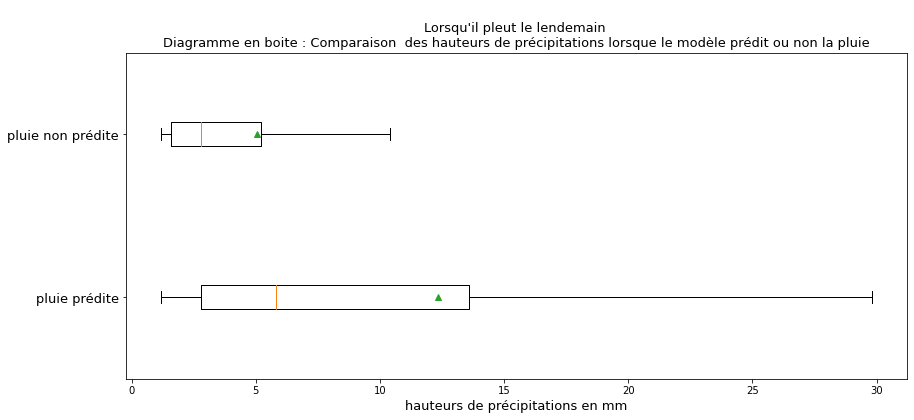

In [49]:
plt.figure (figsize=(14,6))

plt.boxplot([df_vrai_pos['hauteur_pluie_lendemain'], df_faux_neg['hauteur_pluie_lendemain']], sym='', vert=False,showmeans=True)
plt.xlabel('hauteurs de précipitations en mm', size=13)
plt.yticks([1,2],['pluie prédite','pluie non prédite'], size=13)
plt.title("\nLorsqu'il pleut le lendemain \nDiagramme en boite : Comparaison  des hauteurs de précipitations lorsque le modèle prédit ou non la pluie", size=13)
;


**Conclusion - Lorsqu'il pleut dans la réalité le lendemain :**

**Ce diagramme en boite montre clairement que lorsque notre deuxième modèle retenu (sur jeu rééquilibré) ne détecte pas la pluie du lendemain, les précipitations sont beaucoup plus faibles que lorsque le modèle la détecte :**

*** Si la pluie est détectée, la moyenne des précipitations est de 12.3 mm contre 5.1 mm si elle n'est pas détectée.**

*** 25 % des pluies non détectées sont inférieures à 1.6 mm alors que 25 % des pluies détectées sont inférieures à 2.8 mm (Q1).**

*** 50 % des pluies non détectées sont inférieures à 2.8 mm alors que 50 % des pluies détectées sont inférieures à 5.8 mm (médiane).**

*** 75 % des pluies non détectées sont inférieures à 5.2 mm alors que 75 % des pluies détectées sont inférieures à 13.6 mm (Q3).**


## **5.3 Les faux positifs**

**Création d'un tableau contenant uniquement les faux positifs :**

In [50]:
df_faux_pos = df_realite_pred[(df_realite_pred['Prediction']==1) & (df_realite_pred['Realite']==0)]

print(df_faux_pos.shape)
df_faux_pos.head()


(1788, 2)


,Realite,Prediction
87728,0,1
95118,0,1
34087,0,1
67230,0,1
61694,0,1



**Ajout à ce tableau des hauteurs de pluie du lendemain :**

In [51]:
L = []
for i in df_faux_pos.index :
  if df_depart.loc[i+1]['Location']==df_depart.loc[i]['Location'] :
      L.append(df_depart.loc[i+1]['Rainfall'])
  else :
    L.append(np.nan)

df_faux_pos['hauteur_pluie_lendemain'] = L
df_faux_pos.head()


C:\Users\33661\AppData\Local\Temp/ipykernel_10784/1634887770.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_faux_pos['hauteur_pluie_lendemain'] = L


,Realite,Prediction,hauteur_pluie_lendemain
87728,0,1,0.2
95118,0,1,0.0
34087,0,1,0.4
67230,0,1,0.4
61694,0,1,0.2


In [52]:
df_faux_pos.isna().sum()

Realite                    0
Prediction                 0
hauteur_pluie_lendemain    2
dtype: int64

In [53]:
df_faux_pos.dropna(inplace=True)
df_faux_pos.isna().sum()

C:\Users\33661\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Realite                    0
Prediction                 0
hauteur_pluie_lendemain    0
dtype: int64

**Statistiques des faux positifs :**

In [54]:
pd.DataFrame(df_faux_pos['hauteur_pluie_lendemain'].describe())


,hauteur_pluie_lendemain
count,1786.000000
mean,0.216797
std,0.305813
min,0.000000
25%,0.000000
50%,0.000000
75%,0.400000
max,1.000000


In [55]:
p_FP = df_faux_pos[df_faux_pos['hauteur_pluie_lendemain']!=0].shape[0]/df_faux_pos.shape[0]*100

print('Dans',np.round(p_FP,2), '% des cas de faux positifs il y a tout de même de petites pluies (< 1 mm).\n')

Dans 43.62 % des cas de faux positifs il y a tout de même de petites pluies (< 1 mm).



**Conclusion :**

**Lorsque le modèle prévoit par erreur la pluie du lendemain, il y a tout de même de légères précipitations dans 43.62 % des cas mais de hauteur inférieure à 1 mm, le seuil arbitrairement choisi (rappel : ne sont comptabilisées comme 'OUI' dans 'Rain Tomorrow' que les précipitations supérieures au seuil de 1 mm).**

**La moyenne des hauteurs de précipitations du lendemain n'est donc pas nulle et vaut 0.22 mm.**



## **5.4 Les vrais négatifs**

**Création d'un tableau contenant uniquement les vrais négatifs :**

In [56]:
df_vrai_neg = df_realite_pred[(df_realite_pred['Prediction']==0) & (df_realite_pred['Realite']==0)]

print(df_vrai_neg.shape)
df_vrai_neg.head()


(7859, 2)


,Realite,Prediction
100743,0,0
71205,0,0
139970,0,0
76944,0,0
13700,0,0


**Ajout à ce tableau des hauteurs de pluie du lendemain :**

In [57]:
L = []
for i in df_vrai_neg.index :
  if df_depart.loc[i+1]['Location']==df_depart.loc[i]['Location'] :
    L.append(df_depart.loc[i+1]['Rainfall'])
  else :
    L.append(np.nan)
    
df_vrai_neg['hauteur_pluie_lendemain'] = L
df_vrai_neg.head()


C:\Users\33661\AppData\Local\Temp/ipykernel_10784/1057322026.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vrai_neg['hauteur_pluie_lendemain'] = L


,Realite,Prediction,hauteur_pluie_lendemain
100743,0,0,0.2
71205,0,0,0.0
139970,0,0,0.0
76944,0,0,0.6
13700,0,0,0.0


In [58]:
df_vrai_neg.isna().sum()

Realite                    0
Prediction                 0
hauteur_pluie_lendemain    1
dtype: int64

In [59]:
df_vrai_neg.dropna(inplace=True)
df_vrai_neg.isna().sum()

C:\Users\33661\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Realite                    0
Prediction                 0
hauteur_pluie_lendemain    0
dtype: int64

**Statistiques des vrais négatifs :**

In [60]:
pd.DataFrame(df_vrai_neg['hauteur_pluie_lendemain'].describe())


,hauteur_pluie_lendemain
count,7858.000000
mean,0.042886
std,0.149934
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [61]:
p_VN = df_vrai_neg[df_vrai_neg['hauteur_pluie_lendemain']!=0].shape[0]/df_vrai_neg.shape[0]*100

print('Dans',np.round(p_VN,2), '% des cas de vrais négatifs il y a tout de même de petites pluies (< 1 mm).\n')

Dans 10.61 % des cas de vrais négatifs il y a tout de même de petites pluies (< 1 mm).



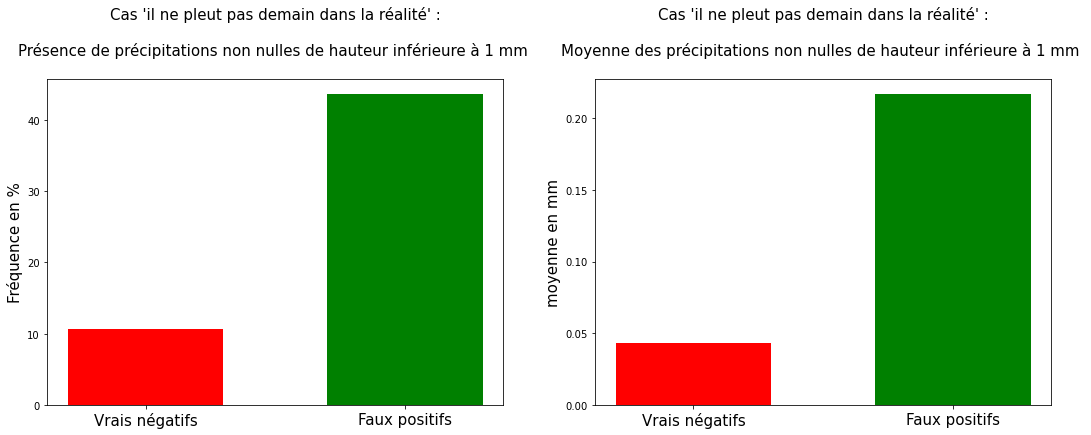

In [62]:
x = ['Vrais négatifs', 'Faux positifs']
y = [p_VN, p_FP]
z = [df_vrai_neg['hauteur_pluie_lendemain'].mean(), df_faux_pos['hauteur_pluie_lendemain'].mean()]
c = ['red', 'green']

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.bar(x,y, width=0.6, color=c)
plt.ylabel('Fréquence en %', size=15)
plt.xticks(size=15)
plt.title("Cas 'il ne pleut pas demain dans la réalité' :\n\nPrésence de précipitations non nulles de hauteur inférieure à 1 mm \n", size=15);

plt.subplot(1,2,2)
plt.bar(x,z, width=0.6, color=c)
plt.ylabel('moyenne en mm', size=15)
plt.xticks(size=15)
plt.title("Cas 'il ne pleut pas demain dans la réalité' :\n\nMoyenne des précipitations non nulles de hauteur inférieure à 1 mm \n", size=15);


**Conclusion - Lorsqu'il ne pleut pas dans la réalité le lendemain :**


**Lorsque le modèle prévoit avec justesse qu'il ne pleut pas le lendemain, il y a tout de même de légères précipitations dans 10.61 % des cas contre 43.62 % des cas lorsque le modèle prévoit par erreur la pluie.**

**La moyenne des hauteurs de précipitations du lendemain est de 0.04 mm lorsque le modèle prévoit avec exactitude qu'il ne pleut pas .**

**La moyenne des hauteurs de précipitations du lendemain est de 0.22 mm lorsque le modèle prévoit à tort qu'il va pleuvoir.**

**Les faibles précipitations (inférieures à 1 mm, non comptabilisées pour la pluie) incitent le modèle à se tromper en indiquant qu'il va pleuvoir le lendemain.**

# **6. Conclusion**

**Pour les deux modèles retenus, avec et sans rééquilibrage de classes, les erreurs de prédictions de pluie sont associées à une fréquence et intensité de petites précipitations (inférieures au seuil de déclenchement 'oui il pleut') beaucoup plus importantes que lorsqu'il ne pleut pas dans la réalité.** 